<a href="https://colab.research.google.com/github/CYNAchille/Tetris_Yanan_Qingchen/blob/main/Yanan_CHEN__Qingchen_YANG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

- Python version 3.7.x
- `pip install -u pip`
- `pip install -r requirements.txt`

#Author: Yanan CHEN, Qingchen YANG

## Problem description

#### Veepee's business description

Veepee is an online flash sales website which offers a large number of new sales everyday with huge discounts up to 70%. Sales are available for a very short period of time.

On Veepee's website, there are **about 200 flash sales on the home page** on a given day divided into several sectors like fashion, accessories, toys, watches, home appliances, sports equipment, technology, wines, travel, etc.

New sales open every day and old sales either continue or stop.

#### Homepage recommendation problem

Because the number of sales (also called operations) is important, users might not scroll until the end of the homepage to see all the banners and might leave Veepee if no sales at the top of the page are relevant to them.

Thus, the main goal of the homepage customization will be to rank the banners so that the most relevant active sales for a customer appear on top of the page.

For that, we rely on the user's previous orders and preferences but also on sales popularity and other global information.

#### First connection issue

Because the ranking algorithm uses members features which are processed once a day, when a user comes for the first time, its home page is not personalized until the next day.

**The goal of these notebooks is to make a first ranking by presenting the user some operations and ask him if he is interested or not.**

# 1 - Random propositions

## Imports

In [1]:
import pandas as pd
import random
import numpy as np

In [2]:
random.seed(84)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Loading the data

The dataframe contains the features of the operation and the related banner. For the train we took all the operations displayed on the homepage on `2020-08-04` (these operation can be new operations or ongoing ones). For the test set, we only took the operations which started in `2020-10-30`.

In [4]:
train_ops = pd.read_pickle("train_2020-08-04.pickle")
test_ops = pd.read_pickle("test_2020-10-30.pickle")

### Operations features

In [5]:
train_ops.head()

,operationcd,secteur_principal,sous_secteur_principal,business_type,brand,operation_type,front_secteur,front_sous_secteur,banner
0,RCLOUD5,DECO / MEUBLE,LITERIE,Vente privée,ROYAL CLOUD,Classique,Maison,Ameublement,b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BI...
1,PBOTTLE4,MATERIEL SPORT,MATÉRIEL OUTDOOR,Vente privée,POP BOTTLES,Classique,Sport,Matériel de sport,b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BI...
2,JDA9,PARCS,PARC D'ATTRACTION,Entertainment,LE JARDIN D ACCLIMATATION_BILLETTERIE,VBI interne,INCONNU,INCONNU,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...
3,BRAX8,PAP FEMME,CLASSIQUE,Vente privée,BRAX,Classique,Mode,Vêtements Femme,b'\xff\xd8\xff\xed\x01\xd6Photoshop 3.0\x008BI...
4,CCO37,DIVERS,DIVERS,Vente privée,CONDOMS & CO,Classique,INCONNU,INCONNU,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...


- `operationcd`: code of the operation
- `secteur_principal`: first level of two of the internal taxonomy
- `sous_secteur_principal`: second level of two of the internal taxonomy
- `business_type`: 'Vente privée', 'Entertainment', 'MEDIA', 'Vin', 'One Day', 'Voyage'
- `brand`: name of the brand
- `operation_type`: 'Classique', 'VBI interne', 'Thématique', 'Vin classique', 'One Day', 'Hotel Planet', 'Séquence caviste'
- `front_secteur`: first level of two of the homepage taxonomy
- `front_sous_secteur`: second level of two of the homepage taxonomy

### Operations banners

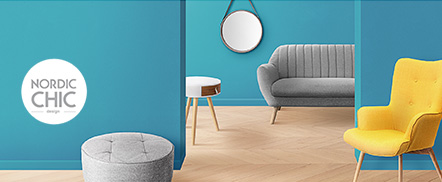

In [6]:
from IPython import display
from base64 import b64decode

display.Image(train_ops.loc[56].banner)

So the homepage consists on 200 banners like this one displayed in two columns. On the banner you will have the brand name of the operation and a specific visual.

## Exercice Setup

In the next cells we will simulate a small survey given to a new user:

We will display operations randomly and ask the user for his/her interest. Each operation is selected completely randomly.

In [7]:
# Imports
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout 

In [8]:
# Add empty column to record actions
train_ops['interested'] = None
test_ops['interested'] = None

In [26]:
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def random_row():
    return random.randint(0, len(train_ops) - 1)


def get_banner(index, dataset):
    return Image(
        value=dataset.loc[index].banner,
        format='jpg',
        width=300,
        height=400,
    )


def plot_grid(df):
    n_rows = (len(df)//3) + (len(df) % 3 != 0)
    grid = GridspecLayout(n_rows , 3)

    cpt = 0
    for i in range(n_rows):
        for j in range(3):
            if cpt < len(df):
                grid[i, j] = get_banner(df.index[cpt], df)
                cpt += 1 
    return grid

In [27]:
# Setting the left button: Not Interested
left_button = create_expanded_button('Not Interested', 'danger')

# Setting the image in the center
current_row_number = random_row()
img = get_banner(current_row_number, train_ops)

# Setting the right button: Interested
right_button = create_expanded_button('Interested', 'success')


def on_button_clicked(b):
    """
    Update the values related to the users choice
    Choose a new operation to display
    Update the banner displayed
    """
    update_values(b)
    row_number = choose_row_number()
    update_banner(b, row_number)
    

def update_values(b):
    """
    Update the dataframe column "interested" using user's action
    """
    global current_row_number

    interested = b.description == "Interested"
    train_ops.loc[current_row_number, 'interested'] = interested
    

def choose_row_number():
    """
    Choose randomly a new operation not already seen
    """
    row_number = random_row()
    if train_ops.loc[row_number].interested is None:
        return row_number
    
    while(train_ops.loc[row_number].interested is not None):
        row_number = random_row()
    
    return row_number


def update_banner(b, row_number):
    """
    Update the value of the image widget with the new banner's string
    """
    global current_row_number

    current_row_number = row_number
    banner = train_ops.loc[current_row_number].banner
    img.value = banner

# Set the on_click function to the button
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# https://ipywidgets.readthedocs.io/en/stable/examples/Layout%20Templates.html#AppLayout
AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

### Sum up operations seen

#### Liked

In [11]:
viewed_ops = train_ops[~train_ops['interested'].isna()]
plot_grid(viewed_ops[viewed_ops.interested])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xed\x01\xd6Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x…

#### Not Liked

In [12]:
plot_grid(viewed_ops[~viewed_ops.interested.astype(bool)])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x…

## Learn and Predict

In [13]:
from sklearn import preprocessing
cat_cols = ['secteur_principal','sous_secteur_principal','business_type','brand','operation_type','front_secteur','front_sous_secteur']
enc = preprocessing.LabelEncoder()
all = pd.concat([train_ops,test_ops])
for col in cat_cols:
    train_ops[col] = train_ops[col].astype('str')
    viewed_ops[col] = viewed_ops[col].astype('str')
    all[col] = all[col].astype('str')
    test_ops[col] = test_ops[col].astype('str')
    all[col] = enc.fit_transform(all[col])
    test_ops[col] = enc.transform(test_ops[col])
    train_ops[col] = enc.transform(train_ops[col])
    viewed_ops[col] = enc.transform(viewed_ops[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [14]:
viewed_ops.head()

,operationcd,secteur_principal,sous_secteur_principal,business_type,brand,operation_type,front_secteur,front_sous_secteur,banner,interested
1,PBOTTLE4,19,55,3,104,0,7,19,b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BI...,False
3,BRAX8,21,15,3,19,0,6,29,b'\xff\xd8\xff\xed\x01\xd6Photoshop 3.0\x008BI...,True
9,GSEB28,24,22,3,59,0,5,8,b'\xff\xd8\xff\xe1\r\x11Exif\x00\x00II*\x00\x0...,False
11,IKOHS7,24,69,3,65,0,5,9,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...,False
27,BEURER68,24,70,3,14,0,5,11,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...,False


### Logistic Regression

Let us first implement a simple logistic regression and learn the user's preferences.

We will then be able to rank the test operations based on the previous feedbacks.

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
###############################################################################
# - Train simple Logistic Regression model on the features and feedbacks      #
# - Make predictions on the test set                                          #
# - Add a new column to the test set with the predicted values                #
###############################################################################
model = LogisticRegression()
x_train = viewed_ops.iloc[:,1:8].astype(int)
y_train = viewed_ops.interested
model.fit(x_train,y_train.astype(int))


test_ops['prediction'] = model.predict_proba(test_ops.iloc[:,1:8])[:,1]

###############################################################################

sorted_ops = test_ops.sort_values(by="prediction", ascending=False)

#### Display ranking on test

In [17]:
plot_grid(sorted_ops)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

### Conclusions

###############################################################################

Your conclusions:
The image correlation in the test set is very low. And when the user selects a picture, the latter picture has absolutely nothing to do with the previous picture.

###############################################################################

In [37]:
%reset -f

# 2 - Online Learning

## The Contextual Bandit

The Contextual Bandit is just like the Multi-Armed bandit problem but now the reward probability distribution depends on external variables. Therefore, we add the notion of **context** or **state** to support our decision.

We're going to suppose that the probabilty of reward is of the form

$$\theta(x) = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \sum_{i=0}^{d}{\beta_i \cdot x_i} + \epsilon$$

which is just assuming that the probability of reward linearly depends of an external variable $x$ with logistic link.

- $x$: the context. Features of the operation.
- $d$: size of the context
- $\beta_i$: the param learned to predict the probability of interest
- $\theta(x)$: The logistic normalization to compute the probability of reward

### Logistic Regression

Let us implement a regular logistic regression, and use an $\epsilon$-greedy policy to choose which bandit to activate. We try to learn the logistic function behind each bandit:

$$\theta(x) = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \sum_{i=0}^{d}{\beta_i \cdot x_i} + \epsilon$$

And select the operation which maximizes $\theta(x)$, except when, with $\epsilon$ probability, we select a random action (excluding the greedy action).

In [38]:
import pandas as pd
import random

In [39]:
random.seed(84)

In [40]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [41]:
train_ops = pd.read_pickle("train_2020-08-04.pickle")
test_ops = pd.read_pickle("test_2020-10-30.pickle")

In [42]:
train_ops['interested'] = None
test_ops['interested'] = None

In [43]:
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout 

In [44]:
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def random_row():
    return random.randint(0, len(train_ops) - 1)


def get_banner(index, dataset):
    return Image(
        value=dataset.loc[index].banner,
        format='jpg',
        width=300,
        height=400,
    )


def plot_grid(df):
    n_rows = (len(df)//3) + (len(df) % 3 != 0)
    grid = GridspecLayout(n_rows , 3)

    cpt = 0
    for i in range(n_rows):
        for j in range(3):
            if cpt < len(df):
                grid[i, j] = get_banner(df.index[cpt], df)
                cpt += 1 
    return grid

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [46]:
cat_cols = ['secteur_principal','sous_secteur_principal','business_type','brand','operation_type','front_secteur','front_sous_secteur']
enc = preprocessing.LabelEncoder()
all = pd.concat([train_ops,test_ops])
for col in cat_cols:
    viewed_ops = train_ops[~train_ops['interested'].isna()]
    train_ops[col] = train_ops[col].astype('str')
    viewed_ops[col] = viewed_ops[col].astype('str')
    all[col] = all[col].astype('str')
    test_ops[col] = test_ops[col].astype('str')
    all[col] = enc.fit_transform(all[col])
    test_ops[col] = enc.transform(test_ops[col])
    train_ops[col] = enc.transform(train_ops[col])
    viewed_ops[col] = enc.transform(viewed_ops[col])

In [47]:
left_button = create_expanded_button('Not Interested', 'danger')

current_row_number = random_row()
img = get_banner(current_row_number, train_ops)

right_button = create_expanded_button('Interested', 'success')

EPSILON = 0.1

def on_button_clicked(b):
    update_values(b)
    row_number = choose_row_number()
    update_banner(b, row_number)

    
def update_values(b):
    global current_row_number
    
    interested = b.description == "Interested"
    train_ops.loc[current_row_number, 'interested'] = interested


def update_banner(b, row_number):
    global current_row_number

    current_row_number = row_number
    banner = train_ops.loc[current_row_number].banner
    img.value = banner
    

def choose_row_number():
###############################################################################
# - Make a random prediction when                                             #
#     - the training is not possible                                          #
#     - a random value is below Ɛ                                             #
# - Else display the most probable operation based on a trained model         #
#   (using the previous algorithm)                                            #
###############################################################################
    y = train_ops.interested
    if random.random() < EPSILON or y.dropna().shape[0]<=4 or y.dropna().unique().shape[0]<2:
      row_number = random_row()
      while(train_ops.loc[row_number].interested is not None):
          row_number = random_row()
      best_row=row_number
    else:
      viewed_ops = train_ops[~train_ops['interested'].isna()]
      model = LogisticRegression(solver="sag",max_iter=100000)
      x_train = viewed_ops.iloc[:,1:8].astype(int)
      y_train = viewed_ops.interested
      model.fit(x_train,y_train.astype(int))

      X=train_ops.iloc[:,1:8].astype(int)
      X.loc[train_ops['interested'].isna(), 'prediction'] = model.predict_proba(X[train_ops['interested'].isna()])[:,1]
      best_row = X.sort_values(by="prediction", ascending=False).index[0]
    
###############################################################################

    return best_row


left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

### Sum up operations seen

#### Liked

In [48]:
viewed_ops = train_ops[~train_ops['interested'].isna()]
plot_grid(viewed_ops[viewed_ops.interested])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

#### Not Liked

In [49]:
plot_grid(viewed_ops[~viewed_ops.interested.astype(bool)])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x…

### Redo Prediction

In [50]:
###############################################################################
# - Train simple Logistic Regression model on the features and feedbacks      #
# - Make predictions on the test set                                          #
# - Add a new column to the test set with the predicted values                #
###############################################################################



model = LogisticRegression()
x_train = viewed_ops.iloc[:,1:8].astype(int)
y_train = viewed_ops.interested
model.fit(x_train,y_train.astype(int))


test_ops['prediction'] = model.predict_proba(test_ops.iloc[:,1:8])[:,1]


###############################################################################

sorted_ops = test_ops.sort_values(by="prediction", ascending=False)

In [51]:
plot_grid(sorted_ops)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

### Conclusions

###############################################################################

Your conclusions:The correlation between pictures is much improved than before. But it takes many selections before the model can start training. The model is prone to fall into local optima..
 
###############################################################################

In [52]:
%reset -f

### Thompson Sampling

In 2011, Chapelle & Li published the paper "[An Empirical Evaluation of Thompson Sampling](https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf)" that helped revive the interest on Thompson Sampling, showing favorable empirical results in comparison to other heuristics. We're going to borrow the Online Logistic Regression algorithm (Algorithm 3) from the paper. Basically, it's a bayesian logistic regression where we define a prior distribution for our weights $\beta_i$, instead of learning just a single value for them (the expectation of the distribution). 

So, our model, just like the greedy algorithm, is:

$$\theta = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \sum_{i=0}^{d}{\beta_i \cdot x_i} + \epsilon$$

but the weights are actually assumed to be distributed as independent gaussians:

$$\beta_i = \mathcal{N}(m_i,q_i^{-1})$$

We initialize all $q_i$'s with a hyperparamenter $\lambda$, which is equivalent to the $\lambda$ used in L2 regularization. Then, at each new training example (or batch of examples) we make the following calculations:

1. Find $\textbf{w}$ as the minimizer of $\frac{1}{2}\sum_{i=1}^{d} q_i(w_i - m_i)^2 + \sum_{j=1}^{n} \textrm{log}(1 + \textrm{exp}(-y_jw^Tx_j))$
2. Update $m_i = w_i$ and perform $q_i = q_i + \sum_{j=1}^{n} x^2_{ij}p_j(1-p_j)$ where $p_j = (1 + \textrm{exp}( -w^Tx_j))^{-1}$ ([Laplace approximation](https://en.wikipedia.org/wiki/Laplace%27s_method))

In essence, we basically altered the logistic regression fitting process to accomodate distributions for the weights. Our Normal priors on the weights are iteratively updated and as the number of observations grow, our uncertainty over their means is reduced. 

We can also increase incentives for exploration or exploitation by defining a hyperparameter $\alpha$, which multiplies the variance of the Normal priors:

$$\beta_i = \mathcal{N}(m_i,\alpha \cdot{} q_i^{-1})$$

With $0 < \alpha < 1$ we reduce the variance of the Normal priors, inducing the algorithm to be greedier, whereas with $\alpha > 1$ we prioritize exploration. Let us implement the algorithm.

- $x$: the context. Features of the operation.
- $\beta_i$: the param learned to predict the probability of interest
- $\theta(x)$: The logistic normalization to compute the probability of reward


- $w$: weights vector
- $m$ and $q$: parameters of the normal priors

In [53]:
import numpy as np
import pandas as pd
import random

In [54]:
random.seed(84)

In [55]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [56]:
train_ops = pd.read_pickle("train_2020-08-04.pickle")
test_ops = pd.read_pickle("test_2020-10-30.pickle")

In [57]:
train_ops['interested'] = None
test_ops['interested'] = None

In [58]:
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout 

In [59]:
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def random_row():
    return random.randint(0, len(train_ops) - 1)


def get_banner(index, dataset):
    return Image(
        value=dataset.loc[index].banner,
        format='jpg',
        width=300,
        height=400,
    )


def plot_grid(df):
    n_rows = (len(df)//3) + (len(df) % 3 != 0)
    grid = GridspecLayout(n_rows , 3)

    cpt = 0
    for i in range(n_rows):
        for j in range(3):
            if cpt < len(df):
                grid[i, j] = get_banner(df.index[cpt], df)
                cpt += 1 
    return grid

In [60]:
from scipy.optimize import minimize

class OnlineLogisticRegression:

    # initializing
    def __init__(self, n_dim, lambda_=5, alpha=5.0):

        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha

        # initializing parameters of the model
        self.n_dim = n_dim,
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_

        # initializing weights
        self.w = np.random.normal(
            self.m,
            self.alpha * (self.q)**(-1.0),
            size = self.n_dim
        )

    # the loss function
    def loss(self, w, *args):
        X, y = args

        #######################################################################
        # Implement the computation of w                                      #
        #######################################################################

        loss = self.q * (w - self.m)-np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)

        
        #######################################################################
        return loss

    # the gradient
    def grad(self, w, *args):
        X, y = args

        second_calculus = (-1) * np.array([
            y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j])))
            for j in range(y.shape[0])
        ]).sum(axis=0)

        w = self.q * (w - self.m) + second_calculus
        
        return w

    # method for sampling weights
    def get_weights(self):
        #######################################################################
        # Implement the computation beta_i                                    #
        #######################################################################
        weights = np.random.normal(self.m, self.alpha*(self.q)**(-1), self.n_dim)

        
        
        
        #######################################################################
        
        return weights

    # fitting method
    def fit(self, X, y):

        # step 1, find w
        self.w = minimize(
            self.loss,
            self.w,
            args=(X, y),
            jac=self.grad,
            method="L-BFGS-B",
            options={'maxiter': 20, 'disp':True}
        ).x
        self.m = self.w

        # step 2, update q
        #######################################################################
        # Update the value of q based on the computation of the p_i
        #######################################################################
        P = (1+np.exp(-1*X.dot(self.m)))**(-1)
        self.q = self.q + (P*(1-P)).dot(X**2)

        
        
        #######################################################################

    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):

        # adding intercept to X
        #X = add_constant(X)

        # sampling weights after update
        self.w = self.get_weights()

        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')

        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

In [61]:
left_button = create_expanded_button('Not Interested', 'danger')

current_row_number = random_row()
img = get_banner(current_row_number, train_ops)

right_button = create_expanded_button('Interested', 'success')


def on_button_clicked(b):
    update_values(b)
    row_number = choose_row_number()
    update_banner(b, row_number)


def update_values(b):
    global current_row_number
    
    interested = b.description == "Interested"
    train_ops.loc[current_row_number, 'interested'] = interested


def update_banner(b, row_number):
    global current_row_number

    current_row_number = row_number
    banner = train_ops.loc[current_row_number].banner
    img.value = banner
    

def choose_row_number():
    # Create the datasets
    X = pd.get_dummies(train_ops[train_ops.columns.difference(['operationcd', 'banner', 'interested'])])
    y = train_ops.interested
    
    # Fit the Model
    olr = OnlineLogisticRegression(
        n_dim=X.shape[1]
    )

    olr.fit(
        X[~y.isna()].values,
        y.dropna().values
    )

    X.loc[y.isna(), 'prediction'] = X[y.isna()].apply(olr.predict_proba, axis=1).apply(pd.Series)[1].values

    # Choose the row
    best_row = X.sort_values(by="prediction", ascending=False).index[0]
    return best_row

    
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

### Sum up operations seen

#### Liked

In [62]:
viewed_ops = train_ops[~train_ops['interested'].isna()]
plot_grid(viewed_ops[viewed_ops.interested])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x…

#### Not Liked

In [63]:
plot_grid(viewed_ops[~viewed_ops.interested.astype(bool)])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

### Redo Prediction

In [64]:
from sklearn import preprocessing
cat_cols = ['secteur_principal','sous_secteur_principal','business_type','brand','operation_type','front_secteur','front_sous_secteur']
enc = preprocessing.LabelEncoder()
all = pd.concat([train_ops,test_ops])
for col in cat_cols:
    train_ops[col] = train_ops[col].astype('str')
    viewed_ops[col] = viewed_ops[col].astype('str')
    all[col] = all[col].astype('str')
    test_ops[col] = test_ops[col].astype('str')
    all[col] = enc.fit_transform(all[col])
    test_ops[col] = enc.transform(test_ops[col])
    train_ops[col] = enc.transform(train_ops[col])
    viewed_ops[col] = enc.transform(viewed_ops[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [65]:
###############################################################################
# - Train the Online Logistic Regression model on the features and feedbacks  #
# - Make predictions on the test set                                          #
# - Add a new column to the test set with the predicted values                #
###############################################################################


x_train = viewed_ops.iloc[:,1:8].astype(int)
y_train = viewed_ops.interested
    
# Fit the Model
olr = OnlineLogisticRegression(
    n_dim= 7
)

olr.fit(x_train.values,y_train.astype(int).values)


test_ops['prediction'] = olr.predict_proba(test_ops.iloc[:,1:8])[:,1]


print(olr)


###############################################################################

sorted_ops = test_ops.sort_values(by="prediction", ascending=False)

In [66]:
plot_grid(sorted_ops)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x14\xb7Exif\x00\x00II*\x00\x08\x00\x00\x00\x0c\x00\x00…

### Conclusions

In these notebooks, we implemented the Contextual Bandit problem and presented two algorithms to solve it. The first, $\epsilon$-greedy, uses a regular logistic regression to get its greedy estimates about the expeceted rewards $\theta(x)$. The second, Thompson Sampling, relies on the Online Logistic Regression to learn an independent normal distribution for each of the linear model weights $\beta_i \sim \mathcal{N}(m_i, q_i ^ -1)$. We draw samples from these Normal posteriors in order to achieve randomization for our bandit choices.

###############################################################################

Your conclusions:The algorithm works very well. Online logistic regression converges very quickly. But it takes longer than regular logistic regression.

###############################################################################